In [1056]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import math
import datetime
import eli5
import shap
import xgboost as xgb
from sklearn import set_config
from eli5.sklearn import PermutationImportance
from haversine import haversine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import  mean_absolute_error
from sklearn.metrics import  mean_squared_error
from sklearn.metrics import  r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.metrics import fbeta_score, make_scorer

# 모든 변수가 보이도록 출력
pd.options.display.max_columns = None 

# 그래프 출력 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 문제제기
# 숙소를 공급하는 입장에서 해당 숙소와 비슷한 숙소의 평균 공급가를 알고 있으면 가격 정책 수립 시 유리할 수 있음
# 신규 호스팅 뿐만 아니라 기존의 숙소 가격을 조정하는데도 비슷한 숙소의 공급가를 알고있는게 좋다.

# 여러 조건들로 요금("price")을 예측하는 회귀문제
# 회귀문제이므로 베이스라인은 평균으로 잡는다.

In [771]:
# 데이터 불러오기
location = "C:\ippo\Data\\tokyo"
df = pd.read_csv(location + "\listings.csv")

# EDA
# 회귀문제 이므로 종속변수를 먼저 확인해보자
# 종속변수는 price(1박기준 요금, 단위는 엔)
target = "price"

# price에 달려표시와 천단위 콤마를 제거
df[target] = df[target].apply(lambda x : int(x.replace("$", "").replace(",", "").split(".")[0]))

# 종속변수의 기술통계량 확인
df[target].describe()

count    1.041400e+04
mean     1.345887e+04
std      4.667056e+04
min      0.000000e+00
25%      4.464000e+03
50%      7.286000e+03
75%      1.280450e+04
max      2.185000e+06
Name: price, dtype: float64

In [772]:
# 종속변수인 요금이 0인 값이 있습니다.
# 의미상 있을 수 없는데이터이고 크기가 크지 않기 때문에 제거하도록 합니다.
print("종속변수(요금)가 0인 case의 개수 :",len(df[df[target]==0]))
df = df[df[target]!=0]

종속변수(요금)가 0인 case의 개수 : 26


Text(0.5, 1.0, '종속변수의 QQ-plot')

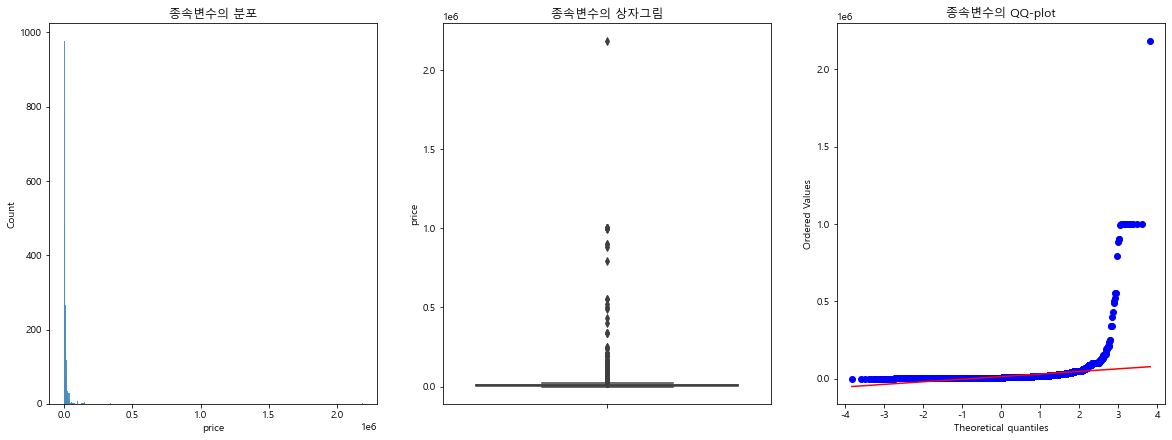

In [773]:
# 종속변수의 분포와 상자그림, QQ-plot 확인
fig, ax = plt.subplots(1,3, figsize=(20,7))
sns.histplot(df[target], ax=ax[0])
ax[0].set_title('종속변수의 분포')
sns.boxplot(y = target,  data = df[[target]], ax=ax[1]) 
ax[1].set_title('종속변수의 상자그림')
stats.probplot(df[target],dist=stats.norm, plot=ax[2])
ax[2].set_title("종속변수의 QQ-plot")

Text(0.5, 1.0, '종속변수의 QQ-plot')

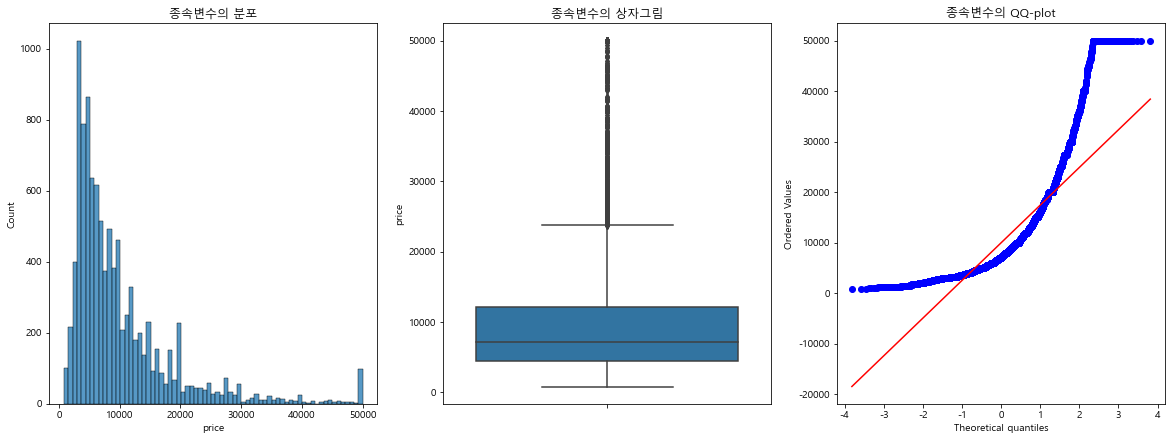

In [774]:
# 상자그림을 확인해보니 극단이상값이 많이 나타납니다 우선 극단이상값을 제거합니다.
# 극단이상값 제거
df = df[df[target]<=50000]

# 극단 이상값 제거후 종속변수 시각화
fig, ax = plt.subplots(1,3, figsize=(20,7))
sns.histplot(df[target], ax=ax[0])
ax[0].set_title('종속변수의 분포')
sns.boxplot(y = target,  data = df[[target]], ax=ax[1]) 
ax[1].set_title('종속변수의 상자그림')
stats.probplot(df[target],dist=stats.norm, plot=ax[2])
ax[2].set_title("종속변수의 QQ-plot")

In [775]:
# 종속변수의 분포가 좌측으로 치우쳐짐
print("종속변수(요금)의 왜도 :", df[target].skew())

종속변수(요금)의 왜도 : 2.2296962879080366


종속변수(요금)의 왜도 : 0.2688591480621658


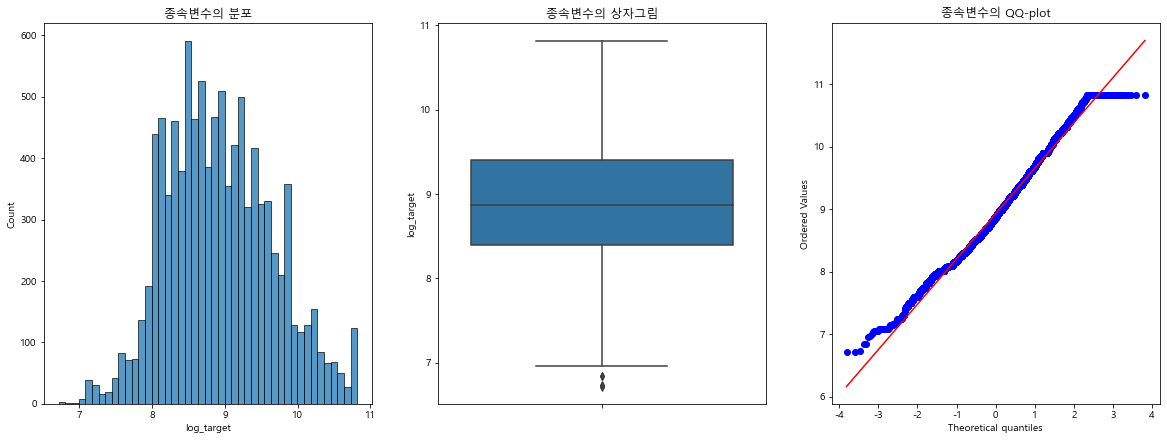

In [776]:
# 로그변환을 통해 대칭성을 확보하도록 합니다.
df["log_target"]=df[target].apply(lambda x : np.log1p(x))

# 종속변수 호그변환후 로그변환된 종속변수 시각화
fig, ax = plt.subplots(1,3, figsize=(20,7))
sns.histplot(df["log_target"], ax=ax[0])
ax[0].set_title('종속변수의 분포')
sns.boxplot(y = "log_target",  data = df[["log_target"]], ax=ax[1]) 
ax[1].set_title('종속변수의 상자그림')
stats.probplot(df["log_target"],dist=stats.norm, plot=ax[2])
ax[2].set_title("종속변수의 QQ-plot")
print("종속변수(요금)의 왜도 :", df["log_target"].skew())

In [777]:
# 데이터 누수를 방지하기 위해 종속변수를 데이터프레임에서 따로 저장합니다.
y = df["log_target"]
feature = df.columns.tolist()
feature.remove("price")
feature.remove("log_target")
df = df[feature]
print("price가 df의 변수에 남아있는가? :" ,"price" in df.columns.tolist())
print("log_target이 df의 변수에 남아있는가? :" ,"log_target" in df.columns.tolist())

price가 df의 변수에 남아있는가? : False
log_target이 df의 변수에 남아있는가? : False


In [778]:
# 결측값을 확인하겠습니다.
pd.DataFrame(df.isna().sum()).T

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,0,0,0,0,0,2577,0,0,0,28,28,28,3381,2737,2737,2076,28,28,28,3467,28,28,0,28,28,2577,0,10173,0,0,0,0,0,10173,41,808,701,0,0,0,0,0,0,0,0,0,10173,0,0,0,0,0,0,0,0,0,2036,2036,2036,2047,2047,2047,2047,2047,2047,7,0,0,0,0,0,2036


In [779]:
# 결측값을 확인해보면 특이하게 모든 관측치가 결측값인 변수가 존재합니다.
# 해당 변수들은 제거하겠습니다.
print("제거된 변수 :", df.columns[df.isna().sum() == len(df)].tolist())
df = df.drop(columns = df.columns[df.isna().sum() == len(df)].tolist())

제거된 변수 : ['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated']


In [780]:
# EDA를 편하게 하기 위해 각 변수별 정보를 출력하는 함수를 만들었습니다.
# 각 변수의 유니크한 값의 개수, 결측값, 결측값이 차지하는 비중, (결측값을 포함한)최빈값이 차지하는 비중, 
def EDA(df):
    col_list = df.columns.tolist()
    unique_list = []
    nan_list = []
    nan_ratio_list = []
    mode_ratio_list = []
    type_list = []
    for col_name in col_list:
        unique_list.append(len(df[col_name].unique()))
        nan_list.append(df[col_name].isna().sum())
        nan_ratio_list.append((df[col_name].isna().sum())/len(df))
        if (df[col_name] == df[col_name].mode()[0]).sum() > df[col_name].isna().sum():
            mode_ratio_list.append((df[col_name] == df[col_name].mode()[0]).sum()/len(df))
        else:
            mode_ratio_list.append(df[col_name].isna().sum()/len(df))
        type_list.append(df.dtypes[col_name])
    df_eda = pd.DataFrame({
        "col_name" : col_list,
        "unique" : unique_list,
        "nan" : nan_list,
        "nan_ratio" : nan_ratio_list,
        "mode_ratio" : mode_ratio_list,
        "type" : type_list
    }).T
    df_eda.columns = col_list
    df_eda = df_eda.iloc[1:]
    return df_eda
EDA(df)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
unique,10173,10173,1,3,9401,7460,3169,9601,2537,2537,1856,1566,255,1664,5,25,56,3,2531,2531,51,66,66,189,3,3,355,49,6284,7093,65,4,16,36,16,24,7329,30,106,30,31,81,79,103,267,2,31,61,91,364,3,278,111,20,1930,1132,130,122,166,121,117,135,124,5540,2,45,43,26,16,563
nan,0,0,0,0,0,0,2577,0,0,0,28,28,28,3381,2737,2737,2076,28,28,28,3467,28,28,0,28,28,2577,0,0,0,0,0,0,41,808,701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2036,2036,2036,2047,2047,2047,2047,2047,2047,7,0,0,0,0,0,2036
nan_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.253318,0.0,0.0,0.0,0.002752,0.002752,0.002752,0.33235,0.269046,0.269046,0.20407,0.002752,0.002752,0.002752,0.340804,0.002752,0.002752,0.0,0.002752,0.002752,0.253318,0.0,0.0,0.0,0.0,0.0,0.0,0.00403,0.079426,0.068908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200138,0.200138,0.200138,0.201219,0.201219,0.201219,0.201219,0.201219,0.201219,0.000688,0.0,0.0,0.0,0.0,0.0,0.200138
mode_ratio,0.000098,0.000098,1.0,0.920181,0.00344,0.004817,0.253318,0.00344,0.009633,0.009633,0.009928,0.011304,0.294407,0.33235,0.621842,0.643468,0.459058,0.653888,0.009633,0.009633,0.340804,0.152659,0.152659,0.222058,0.996756,0.891477,0.253318,0.207707,0.002064,0.001868,0.488941,0.676693,0.300501,0.530522,0.693896,0.302762,0.009633,0.611521,0.411973,0.636292,0.567581,0.555392,0.587339,0.576329,0.555392,0.99656,0.257151,0.200727,0.165438,0.111275,0.920181,0.200138,0.467414,0.829844,0.200138,0.200138,0.200138,0.201219,0.201219,0.244962,0.24624,0.201219,0.201219,0.00865,0.759068,0.106458,0.249091,0.638553,0.929421,0.200138
type,int64,object,int64,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object,object,object,object,object,float64,float64,object,object,int64,object,float64,float64,object,int64,int64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64,object,int64,int64,int64,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,int64,int64,int64,int64,float64


In [781]:
# 데이터의 자료형에 오류가 있는 변수들을 수정해줍니다.
df["id"] = df["id"].apply(lambda x : str(x))
df["host_id"] = df["host_id"].apply(lambda x : str(x))
df["last_scraped"] = pd.to_datetime(df["last_scraped"])
df["host_since"] = pd.to_datetime(df["host_since"])
df["first_review"] = pd.to_datetime(df["first_review"])
df["last_review"] = pd.to_datetime(df["last_review"])
df["calendar_last_scraped"] = pd.to_datetime(df["calendar_last_scraped"])
def per_to_int(x):
    try:
        return int(x.replace("%", ""))
    except:
        return x    
df["host_response_rate"] = df["host_response_rate"].apply(per_to_int)
df["host_acceptance_rate"] = df["host_acceptance_rate"].apply(per_to_int)

In [782]:
# Feature Engineering
# data의 통계량을 사용하지 않았습니다

# 결측값과 결측값이 아닌것으로 바꿔주는 함수
# 결측값이면 0 아니면 1
def binclass(col):
    return df[col].apply(lambda x : 0 if pd.isna(x) else 1)

# 결측값이 최빈값이고 cardinailty가 너무 높습니다.
# neighborhood_overview가 있는지 없는지로 데이터를 변환합니다.
df["neighborhood_overview"] = binclass("neighborhood_overview")

# 호스팅을 시작한 날부터 기준일(2021년 10월 29일) 까지의 일수로 변환
last_scraped = datetime.datetime(2021,10,29)
def host_since(x):
    try:
        return x.days
    except:
        return x    
df["host_since"] = last_scraped - df["host_since"]
df["host_since"] = df["host_since"].apply(host_since)

# 결측값이 최빈값이고 cardinailty가 너무 높습니다.
# host_about가 있는지 없는지로 데이터를 변환합니다.
df["host_about"] = binclass("host_about")

# host_neighbourhood가 있는지 없는가로 새로운 데이터를 만듭니다.
df["binclass_host_neighbourhood"] = binclass("host_neighbourhood")

# 개수로 변환
def host_verification(x):
    try:
        return len(x.split(","))
    except:
        return 0
df["host_verifications"] = df["host_verifications"].apply(host_verification)

# 프라이버시의 정도를 변환
def property_type(x):
    try : 
        if "Entire" in x:
            return "Entire"
        elif "Shared" in x:
            return "Shared"
        elif "Private" in x:
            return "Private"
        else:
            return "ect"
    except :
        return x        
df["property_type"] = df["property_type"].apply(property_type)

# bathrooms
# shared 유무로 변수를 하나추가
def shared_bathrooms(x):
    try :
        if "shared" in x.lower():
            return 1
        elif x == "0 baths":
            return 1
        else:
            return 0
    except :
        return x               
df["shared_bathrooms"] = df["bathrooms_text"].apply(shared_bathrooms)

# private 유무로 변수를 하나추가
def private_bathrooms(x):
    try : 
        if "private" in x.lower():
            return 1
        elif x == "0 baths":
            return 1
        else:
            return 0        
    except:
        return x        
df["private_bathrooms"] = df["bathrooms_text"].apply(private_bathrooms)

# 개수만 숫자로 변환
def bathrooms_text(x):
    try : 
        if "half" in x.lower():
            return 0.5 
        else:
            return float(x.split()[0])
    except :
        return x        
df["bathrooms_text"] = df["bathrooms_text"].apply(bathrooms_text)

# 편의시설의 개수 변수 생성
df["no_of_amenities"] = df["amenities"].apply(lambda x : int(len(x.split(","))))
# 에어컨의 유무 변수 생성
df["Air conditioning"] = df["amenities"].apply(lambda x: 1 if "Air conditioning" in x else 0)
# 와이파이 유무 변수 생성
df["Wifi"] = df["amenities"].apply(lambda x: 1 if "Wifi" in x else 0)
# 세탁기 유무 변수 생성
df["Washer"] = df["amenities"].apply(lambda x: 1 if "Washer" in x else 0)

# 첫번째 리뷰, 마지막리뷰의 기준일(2021년 10월 29일) 까지의 일수로 변환
df["first_review"] = last_scraped - df["first_review"]
df["first_review"] = df["first_review"].apply(host_since)
df["last_review"] = last_scraped - df["last_review"]
df["last_review"] = df["last_review"].apply(host_since)

# 숙소의 위치 좌표 생성
df['location'] = list(zip(df['latitude'], df["longitude"]))

# 하네다 공항과 숙소의 직선 km 거리변수 생성
haneda = (35.549993352187784, 139.7840549611764)
df["haneda"] = df["location"].apply(lambda x : haversine(x, haneda))

# 나리타 공항과 숙소의 직선 km 거리변수 생성
narita = (35.772038909183955, 140.39283936879917)
df["narita"] = df["location"].apply(lambda x : haversine(x, narita))

# 시부야 교차로와 숙소의 직선 km 거리변수 생성
shibuya = (35.65946900895085, 139.700531052387)
df["shibuya"] = df["location"].apply(lambda x : haversine(x, shibuya))

# 도쿄 스카이트리와 숙소의 직선 km 거리변수 생성
tokyo_sky_tree = (35.7100224380305, 139.81075968326326)
df["tokyo_sky_tree"] = df["location"].apply(lambda x : haversine(x, tokyo_sky_tree))

# 오다이바와 숙소의 직선 km 거리변수 생성
odaiba = (35.61514810225738, 139.78216180613242)
df["odaiba"] = df["location"].apply(lambda x : haversine(x, odaiba))

In [783]:
import folium
map = folium.Map(location = [35.7100224380305, 139.81075968326326], zoom_start =10)
for i in [odaiba, tokyo_sky_tree, haneda, narita, shibuya]:
    folium.Marker(list(i)).add_to(map)
map

In [784]:
# 명목형 변수중 극단적 high cardinailty 변수들을 제거합니다.
# 제거 기준은 최빈값이 차지하는 비중이 0.01 보다 작은 object type변수입니다. 
high_cardinailty = EDA(df).T[(EDA(df).T["mode_ratio"]<0.01) & (EDA(df).T["type"]=="object")].index.tolist()
df = df.drop(columns=high_cardinailty)
print("제거된 변수 :",high_cardinailty)

제거된 변수 : ['id', 'listing_url', 'name', 'description', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url', 'amenities', 'license', 'location']


<AxesSubplot:>

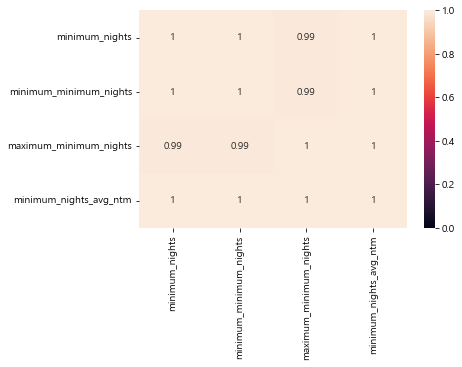

In [785]:
sns.heatmap(df[["minimum_nights",'minimum_minimum_nights','maximum_minimum_nights','minimum_nights_avg_ntm']].corr(), annot=True, vmin=0, vmax=1)

<AxesSubplot:>

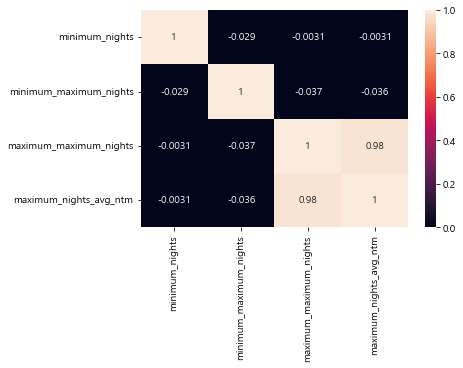

In [786]:
sns.heatmap(df[["minimum_nights",'minimum_maximum_nights','maximum_maximum_nights','maximum_nights_avg_ntm']].corr(), annot=True, vmin=0, vmax=1)

In [787]:
df[["neighbourhood_cleansed", "neighbourhood"]][df[["neighbourhood_cleansed", "neighbourhood"]]["neighbourhood"].isna()==False]

,neighbourhood_cleansed,neighbourhood
1,Kita Ku,"Kita-ku, Tokyo, Japan"
2,Adachi Ku,"足立区, 東京都, Japan"
4,Katsushika Ku,"Katsushika, Tokyo, Japan"
7,Toshima Ku,"Toshima, Tokyo, Japan"
8,Toshima Ku,"Toshima, Tokyo, Japan"
...,...,...
10394,Sumida Ku,"Sumida City, Tokyo, Japan"
10396,Shinjuku Ku,"Shinjuku City, Tokyo, Japan"
10399,Toshima Ku,"Toshima City, Tokyo, Japan"
10400,Toshima Ku,"Toshima City, Tokyo, Japan"


In [788]:
df[["host_total_listings_count", "host_listings_count"]][df[["host_total_listings_count", "host_listings_count"]]["host_listings_count"].isna()==False]

,host_total_listings_count,host_listings_count
0,1.0,1.0
1,1.0,1.0
2,2.0,2.0
3,1.0,1.0
4,3.0,3.0
...,...,...
10409,119.0,119.0
10410,119.0,119.0
10411,88.0,88.0
10412,88.0,88.0


In [789]:
df["host_location"].value_counts()

JP                                        2995
Tokyo, Japan                              1469
Tokyo, Tokyo, Japan                        822
Shinjuku City, Tokyo, Japan                342
Shinjuku, Tokyo, Japan                     283
                                          ... 
Niiza, Saitama Prefecture, Japan             1
Funabashi, Chiba, Japan                      1
Inzai, Chiba Prefecture, Japan               1
Tonosho, Shozu District, Kagawa, Japan       1
Taito-ku, Tōkyō-to, Japan                    1
Name: host_location, Length: 254, dtype: int64

In [790]:
# 의미가 없는 변수를 제거합니다
df = df.drop(columns=[
    'scrape_id',                # unique한 값이 한개입니다. 의미가 없는 변수이므로 제거합니다.
    'last_scraped',             # 마지막으로 스크레이핑 된 날자입니다. 예측할때 사용할 수 없는 변수이므로 제거합니다.
    "host_location",            # 변수가 실질적으로 의미가 없습니다. 변수의 대부분이 같은 의미이므로 제거합니다.
    "host_total_listings_count",# host_listings_count와 동일한 변수입니다. 다른 변수에 모든 의미가 포함되므로 제거합니다.
    "neighbourhood",            # neighbourhood_cleansed에 모든 정보가 담겨있는 변수입니다. 다른 변수에 모든 의미가 포함되므로 제거합니다.
    "calendar_last_scraped",    # Calendar라는 다른 데이터셋에서의 스크레이핑 날자입니다. 예측할때 사용할 수 없는 변수이므로 제거합니다.
    'minimum_minimum_nights',   # minimum_nights와 대부분의 관측치가 동일합니다. 다른 변수에 대부분의 의미가 포함 되므로 제거합니다.
    'maximum_minimum_nights',	# minimum_nights와 대부분의 관측치가 동일합니다. 다른 변수에 대부분의 의미가 포함 되므로 제거합니다.
    'minimum_nights_avg_ntm',	# minimum_nights와 대부분의 관측치가 동일합니다. 다른 변수에 대부분의 의미가 포함 되므로 제거합니다.
    'maximum_nights_avg_ntm'    # maximum_maximum_nights와 대부분의 관측치가 동일합니다. 다른 변수에 대부분의 의미가 포함 되므로 제거합니다.
])

In [791]:
def check_binclass(col, df):
    sns.boxplot(x = col, y = "log_target", data=df)
    a = df[df[col]==df[col].value_counts().index[0]]["log_target"]
    b = df[df[col]==df[col].value_counts().index[1]]["log_target"]
    if stats.levene(a,b)[1] < 0.05:
        p_val = stats.ttest_ind(a,b,equal_var = False)[1]
        print("이분산")
    else :
        p_val = stats.ttest_ind(a,b,equal_var = True)[1]
        print("등분산")
    if p_val < 0.05:
        print( col+"에 따른 log target의 평균의 차이는 있다")
    else:
        print( col+"에 따른 log target의 평균의 차이는 없다")
        return col

이분산
Washer에 따른 log target의 평균의 차이는 있다


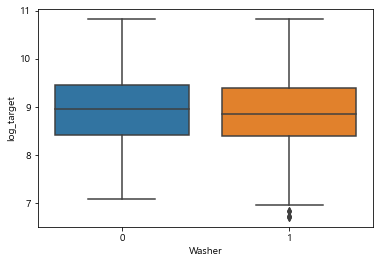

In [792]:
X = df
# test_set 분리
X_train, X_test , y_train, y_test = train_test_split(X, y,train_size = 0.8, random_state=2)
# 검증 데이터 분리
X_train, X_val , y_train, y_val = train_test_split(X_train, y_train,train_size = 0.8, random_state=2)
check_binclass("Washer", pd.concat([y_train,X_train],axis=1))

이분산
neighborhood_overview에 따른 log target의 평균의 차이는 있다
이분산
host_about에 따른 log target의 평균의 차이는 없다
이분산
has_availability에 따른 log target의 평균의 차이는 있다
이분산
instant_bookable에 따른 log target의 평균의 차이는 있다
등분산
binclass_host_neighbourhood에 따른 log target의 평균의 차이는 있다
등분산
Air conditioning에 따른 log target의 평균의 차이는 없다
등분산
Wifi에 따른 log target의 평균의 차이는 없다
이분산
Washer에 따른 log target의 평균의 차이는 있다


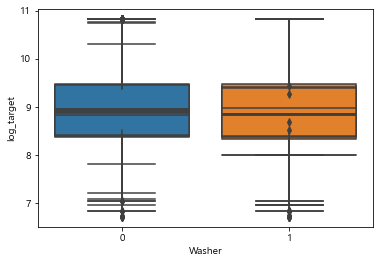

In [793]:
X = df
# test_set 분리
X_train, X_test , y_train, y_test = train_test_split(X, y,train_size = 0.8, random_state=2)
# 검증 데이터 분리
X_train, X_val , y_train, y_val = train_test_split(X_train, y_train,train_size = 0.8, random_state=2)

listting = []
for i in EDA(df).T[EDA(df).T["unique"]==2].index.tolist():
    listting.append(check_binclass(i, pd.concat([y_train,X_train],axis=1)))
list(filter(None, listting))

df = df.drop(columns=list(filter(None, listting)))

In [870]:
X = df
features = X.columns.tolist()
print("price가 df의 변수에 남아있는가? :" ,"price" in X.columns.tolist())
print("log_target이 df의 변수에 남아있는가? :" ,"log_target" in X.columns.tolist())
print("사용하는 변수의 개수 :", len(features))

price가 df의 변수에 남아있는가? : False
log_target이 df의 변수에 남아있는가? : False
사용하는 변수의 개수 : 57


In [796]:
# 결측값의 비중이 크지 않은 변수들은 최빈값으로 결측치를 대체한다.
most_freq_impute = EDA(df).T[EDA(df).T["nan_ratio"]<0.1].index.tolist()
print(most_freq_impute)

['neighborhood_overview', 'host_since', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'binclass_host_neighbourhood', 'shared_bathrooms', 'private_bathrooms', 'no_of_amenities', 'Washer', 'haneda', 'narita', 'shibuya', 'tokyo_sky_tree', 'odaiba']


In [797]:
# 결측값의 비중이 큰 범주형 변수는 결측값을 "a_nan" 으로 대체한다.
nan_impute = EDA(df).T[(EDA(df).T["nan_ratio"]>=0.1)&(EDA(df).T["type"]=="object")].index.tolist()
print(nan_impute)

['host_response_time', 'host_neighbourhood']


In [798]:
# 결측값의 비중이 큰 숫자형 변수는 KNNImputer로 대체한다.
knn_impute = EDA(df).T[(EDA(df).T["nan_ratio"]>=0.1)&(EDA(df).T["type"]!="object")].index.tolist()
print(knn_impute)

['host_response_rate', 'host_acceptance_rate', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']


In [871]:
# 결측치 대체
most_freq_impute_pipe = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(strategy="most_frequent"))     
    ]
)

nan_impute_pipe = Pipeline(
    steps=[
        ("imputation_constant", SimpleImputer(strategy="constant", fill_value = "a_nan"))
    ]
)

knn_impute_pipe = Pipeline(
    steps=[
        ("imputation_constant", KNNImputer())
    ]
)

imputer = ColumnTransformer(
    [
        ("most_freq_impute", most_freq_impute_pipe, most_freq_impute),
        ("nan_impute", nan_impute_pipe, nan_impute),
        ("iterative_impute", knn_impute_pipe, knn_impute)
    ]
)
# 결측치 대체
X = pd.DataFrame(imputer.fit_transform(X))
imputed_features = most_freq_impute + nan_impute + knn_impute
X.columns = imputed_features
for i in X.columns.tolist():
    try:
        X[i] = X[i].apply(lambda x : float(x))
    except:
        continue

In [872]:
# test_set 분리
X_train, X_test , y_train, y_test = train_test_split(X, y,train_size = 0.8, random_state=2)

# 검증 데이터 분리
X_train, X_val , y_train, y_val = train_test_split(X_train, y_train,train_size = 0.8, random_state=2)

In [873]:
# 모델의 평가지표 확인
def performance(pipe):
    exp_y_train = np.expm1(y_train)
    exp_y_val = np.expm1(y_val)
    exp_y_pred_train = np.expm1(pipe.predict(X_train))
    exp_y_pred_val = np.expm1(pipe.predict(X_val))
    exp_y_pred_base = np.expm1(np.array([y_train.mean()]*len(y_val)))
    print("train MAE :", mean_absolute_error(exp_y_train, exp_y_pred_train))
    print("val MAE :", mean_absolute_error(exp_y_val, exp_y_pred_val))
    print("base model val MAE :", mean_absolute_error(exp_y_val, exp_y_pred_base))
    return mean_absolute_error(exp_y_val, exp_y_pred_val)
def final_performance(pipe):
    exp_y_test = np.expm1(y_test)
    exp_y_pred_test = np.expm1(pipe.predict(X_test))
    print("test MAE :", mean_absolute_error(exp_y_test, exp_y_pred_test))
    return mean_absolute_error(exp_y_test, exp_y_pred_test)
    
# 로그 변환의 역함수를 취한 MAE를 기준으로 모델을 선택하도록 새로운 Score기준을 만든다    
def my_custom_loss_func(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    return np.mean(np.abs(y_true - y_pred))
score = make_scorer(my_custom_loss_func, greater_is_better=False)

In [875]:
# pipe line 작성
preprocessor = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ]
)
set_config(display="diagram")
preprocessor

Pipeline(steps=[('encoder', OrdinalEncoder())])

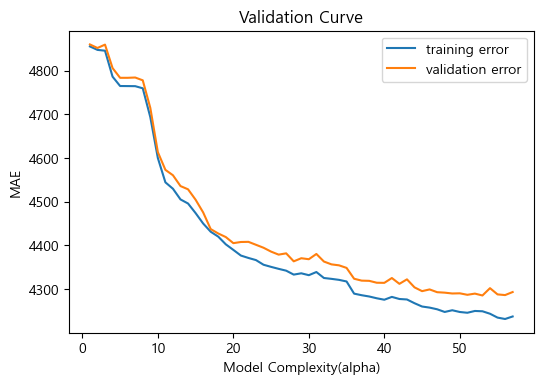

In [953]:
LR_pipe = Pipeline(
    steps=[
    ("Onehot", OneHotEncoder()),
    ("select", SelectKBest(f_regression)),
    ("Regression", LinearRegression(n_jobs=-1, normalize=True))]
)

alpha = np.arange(1, 58, 1)
ts, vs = validation_curve(
    LR_pipe, X_train, y_train
    , param_name='select__k'
    , param_range=alpha, scoring=score
    , cv=3
    , n_jobs=-1
)
train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)
fig, ax = plt.subplots()
ax.plot(alpha, train_scores_mean, label='training error')
ax.plot(alpha, validation_scores_mean, label='validation error')
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(alpha)', ylabel='MAE')
ax.legend()
fig.dpi = 100

In [955]:
LR_pipe = Pipeline(
    steps=[
    ("Onehot", OneHotEncoder()),
    ("select", SelectKBest(f_regression, k=53)),
    ("Regression", LinearRegression(n_jobs=-1, normalize=True))]
)
LR_pipe.fit(X_train, y_train)
LR_pipe

Pipeline(steps=[('Onehot',
                 OneHotEncoder(cols=['host_is_superhost',
                                     'host_has_profile_pic',
                                     'host_identity_verified',
                                     'neighbourhood_cleansed', 'property_type',
                                     'room_type', 'has_availability',
                                     'instant_bookable', 'host_response_time',
                                     'host_neighbourhood'])),
                ('select',
                 SelectKBest(k=53,
                             score_func=<function f_regression at 0x0000018022B4D040>)),
                ('Regression', LinearRegression(n_jobs=-1, normalize=True))])

In [957]:
performance(LR_pipe)

train MAE : 4250.427084039916
val MAE : 4581.37194053977
base model val MAE : 5657.2159429702715


4581.37194053977

<class 'list'>
<class 'list'>


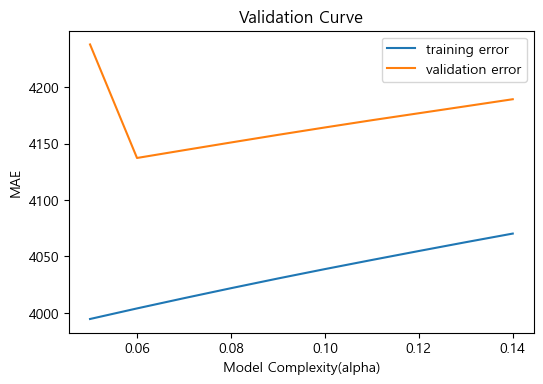

In [991]:
# Ridge Regression
# 3-Fold CV
RR_pipe = Pipeline(
    steps=[
    ("Onehot", OneHotEncoder()),
    ("Regression", Ridge(normalize=True))]
)

alpha = np.arange(0.05, 0.15, 0.01)
ts, vs = validation_curve(
    RR_pipe, X_train, y_train
    , param_name='Regression__alpha'
    , param_range=alpha, scoring=score
    , cv=3
    , n_jobs=-1
)
train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)
validation_scores_mean = [-vs[0,2]] + list(validation_scores_mean[-9:])
fig, ax = plt.subplots()
ax.plot(alpha, train_scores_mean, label='training error')
ax.plot(alpha, validation_scores_mean, label='validation error')
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(alpha)', ylabel='MAE')
ax.legend()
fig.dpi = 100

In [993]:
RR_pipe = Pipeline(
    steps=[
    ("Onehot", OneHotEncoder()),
    ("Regression", Ridge(normalize=True, alpha= 0.06))]
)
RR_pipe.fit(X_train, y_train)
RR_pipe

Pipeline(steps=[('Onehot',
                 OneHotEncoder(cols=['host_is_superhost',
                                     'host_has_profile_pic',
                                     'host_identity_verified',
                                     'neighbourhood_cleansed', 'property_type',
                                     'room_type', 'has_availability',
                                     'instant_bookable', 'host_response_time',
                                     'host_neighbourhood'])),
                ('Regression', Ridge(alpha=0.06, normalize=True))])

In [994]:
performance(RR_pipe)

train MAE : 4027.389210995152
val MAE : 4411.140002803976
base model val MAE : 5657.2159429702715


4411.140002803976

In [897]:
# Tree-based model
# DecisionTreeRegressor
# 3-Fold CV
DT_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", DecisionTreeRegressor())]
)
dists = {
    'Regression__min_samples_leaf' : np.arange(10, 100, 10),
    'Regression__min_samples_split' : np.arange(10, 100, 10),
    'Regression__max_depth' : np.arange(2,21,2)
}
clf = RandomizedSearchCV(
    DT_pipe, 
    param_distributions=dists,
    n_iter=50,
    cv=3,
    scoring=score,
    verbose=1,
    n_jobs=-1 
)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('encoder',
                                                               OrdinalEncoder(cols=['host_is_superhost',
                                                                                    'host_has_profile_pic',
                                                                                    'host_identity_verified',
                                                                                    'neighbourhood_cleansed',
                                                                                    'property_type',
                                                                                    'room_type',
                                                                                    'has_availability',
                                                                                    'instant_bookable',
                                                                                    'host_response_time',
                                                                                    'host_neighbourhood'],
                                                                              mapping=[{'col': 'host_is_superhost...
                                             ('Regression',
                                              DecisionTreeRegressor())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'Regression__max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'Regression__min_samples_leaf': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                                        'Regression__min_samples_split': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   scoring=make_scorer(my_custom_loss_func, greater_is_better=False),
                   verbose=1)

In [898]:
clf.best_params_

{'Regression__min_samples_split': 40,
 'Regression__min_samples_leaf': 20,
 'Regression__max_depth': 16}

In [996]:
DT_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", DecisionTreeRegressor())]
)
dists = {
    'Regression__min_samples_leaf' : np.arange(18, 23, 1),
    'Regression__min_samples_split' : np.arange(38, 43, 1),
    'Regression__max_depth' : np.arange(13,18,1)
}
clf = GridSearchCV(
    DT_pipe, 
    param_grid=dists,
    cv=3,
    scoring=score,
    verbose=1,
    n_jobs=-1 
)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('encoder',
                                                         OrdinalEncoder(cols=['host_is_superhost',
                                                                              'host_has_profile_pic',
                                                                              'host_identity_verified',
                                                                              'neighbourhood_cleansed',
                                                                              'property_type',
                                                                              'room_type',
                                                                              'has_availability',
                                                                              'instant_bookable',
                                                                              'host_response_time',
                                                                              'host_neighbourhood'],
                                                                        mapping=[{'col': 'host_is_superhost',
                                                                                  'dat...
Nishinari-ku           47
Naniwa-ku              48
Harajuku               49
NaN                    -2
dtype: int64}]))])),
                                       ('Regression',
                                        DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'Regression__max_depth': array([13, 14, 15, 16, 17]),
                         'Regression__min_samples_leaf': array([18, 19, 20, 21, 22]),
                         'Regression__min_samples_split': array([38, 39, 40, 41, 42])},
             scoring=make_scorer(my_custom_loss_func, greater_is_better=False),
             verbose=1)

In [997]:
clf.best_params_

{'Regression__max_depth': 14,
 'Regression__min_samples_leaf': 19,
 'Regression__min_samples_split': 41}

In [998]:
DT_pipe = clf.best_estimator_
DT_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoder',
                                  OrdinalEncoder(cols=['host_is_superhost',
                                                       'host_has_profile_pic',
                                                       'host_identity_verified',
                                                       'neighbourhood_cleansed',
                                                       'property_type',
                                                       'room_type',
                                                       'has_availability',
                                                       'instant_bookable',
                                                       'host_response_time',
                                                       'host_neighbourhood'],
                                                 mapping=[{'col': 'host_is_superhost',
                                                           'data_type': dtype('O'),
                                                           'mapping'...
Marunouchi             31
Shibuya                32
Adachi District        33
Aoyama                 34
Konohana-ku            35
Island of Hawaiʻi      36
Tsukishima             37
Ebisu/Daikanyama       38
Shimokitazawa          39
Chūō-ku                40
Ginza                  41
Meguro District        42
Nakameguro             43
Fushimi-ku             44
Higashiyama-ku         45
Kita-ku                46
Nishinari-ku           47
Naniwa-ku              48
Harajuku               49
NaN                    -2
dtype: int64}]))])),
                ('Regression',
                 DecisionTreeRegressor(max_depth=14, min_samples_leaf=19,
                                       min_samples_split=41))])

In [999]:
performance(DT_pipe)

train MAE : 3121.0934567150684
val MAE : 3890.946422788169
base model val MAE : 5657.2159429702715


3890.946422788169

In [1000]:
# Ensemble model (Bagging)
# RandomForestRegressor
RF_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", RandomForestRegressor(n_jobs=-1))]
)
dists = {
    'Regression__min_samples_leaf' : [1,2],
    'Regression__min_samples_split' : [2,3],
    'Regression__max_depth' : [25,None]
}
clf = GridSearchCV(
    RF_pipe, 
    param_grid=dists,
    cv=3,
    scoring=score,
    verbose=1,
    n_jobs=-1 
)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'Regression__max_depth': 25,
 'Regression__min_samples_leaf': 1,
 'Regression__min_samples_split': 2}

In [1001]:
RF_pipe = clf.best_estimator_
RF_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoder',
                                  OrdinalEncoder(cols=['host_is_superhost',
                                                       'host_has_profile_pic',
                                                       'host_identity_verified',
                                                       'neighbourhood_cleansed',
                                                       'property_type',
                                                       'room_type',
                                                       'has_availability',
                                                       'instant_bookable',
                                                       'host_response_time',
                                                       'host_neighbourhood'],
                                                 mapping=[{'col': 'host_is_superhost',
                                                           'data_type': dtype('O'),
                                                           'mapping'...
Suginami District      28
Itabashi District      29
Da'an                  30
Marunouchi             31
Shibuya                32
Adachi District        33
Aoyama                 34
Konohana-ku            35
Island of Hawaiʻi      36
Tsukishima             37
Ebisu/Daikanyama       38
Shimokitazawa          39
Chūō-ku                40
Ginza                  41
Meguro District        42
Nakameguro             43
Fushimi-ku             44
Higashiyama-ku         45
Kita-ku                46
Nishinari-ku           47
Naniwa-ku              48
Harajuku               49
NaN                    -2
dtype: int64}]))])),
                ('Regression', RandomForestRegressor(max_depth=25, n_jobs=-1))])

In [1002]:
performance(RF_pipe)

train MAE : 1224.033409467854
val MAE : 2996.377625305844
base model val MAE : 5657.2159429702715


2996.377625305844

In [906]:
# Ensemble model (Boosting)
# Gradient Boosting
# XGBRegressor
XG_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", XGBRegressor(n_jobs=-1))]
)
XG_pipe.fit(X_train, y_train)
performance(XG_pipe)

train MAE : 1184.48143078032
val MAE : 3002.9290325717784
base model val MAE : 5657.2159429702715


3002.9290325717784

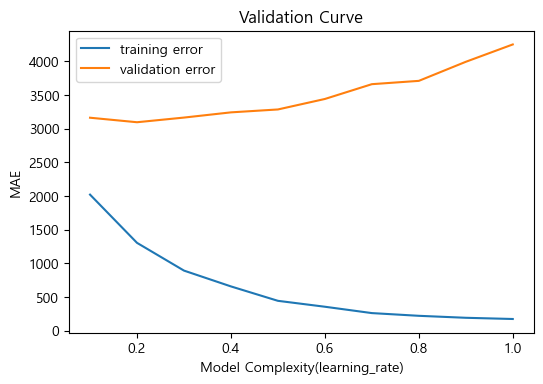

In [907]:
XG_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", XGBRegressor(n_jobs=-1))]
)
alpha = np.arange(0.1, 1.1, 0.1)
ts, vs = validation_curve(
    XG_pipe, X_train, y_train
    , param_name='Regression__learning_rate'
    , param_range=alpha, scoring=score
    , cv=3
    , n_jobs=-1
)
train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)
fig, ax = plt.subplots()
ax.plot(alpha, train_scores_mean, label='training error')
ax.plot(alpha, validation_scores_mean, label='validation error')
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(learning_rate)', ylabel='MAE')
ax.legend()
fig.dpi = 100

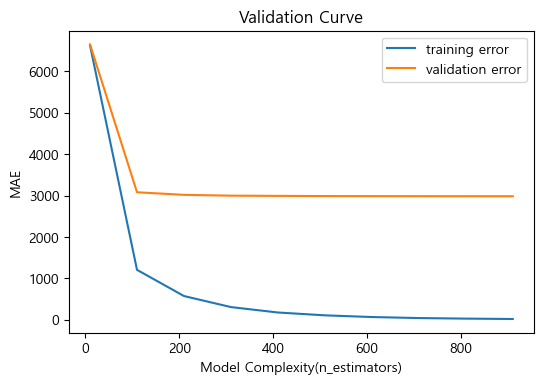

In [1007]:
XG_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", XGBRegressor(n_jobs=-1, learning_rate=0.2))]
)
alpha = np.arange(10, 1000, 100)
ts, vs = validation_curve(
    XG_pipe, X_train, y_train
    , param_name='Regression__n_estimators'
    , param_range=alpha, scoring=score
    , cv=3
    , n_jobs=-1
)
train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)
fig, ax = plt.subplots()
ax.plot(alpha, train_scores_mean, label='training error')
ax.plot(alpha, validation_scores_mean, label='validation error')
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(n_estimators)', ylabel='MAE')
ax.legend()
fig.dpi = 100

In [1008]:
XG_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", XGBRegressor(n_jobs=-1, learning_rate=0.2, n_estimators=100))]
)
XG_pipe.fit(X_train, y_train)
performance(XG_pipe)

train MAE : 1440.8000234108733
val MAE : 2920.6762579090764
base model val MAE : 5657.2159429702715


2920.6762579090764

In [910]:
XG_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", XGBRegressor(n_jobs=-1))]
)
dists = {
    'Regression__learning_rate' : np.arange(0.1, 0.31, 0.1),
    'Regression__n_estimators' : np.arange(100, 200, 10),
    'Regression__max_depth' : np.arange(50,160,10)
}
clf = RandomizedSearchCV(
    XG_pipe, 
    param_distributions=dists,
    cv=3,
    n_iter=50,
    scoring=score,
    verbose=1,
    n_jobs=-1 
)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'Regression__n_estimators': 170,
 'Regression__max_depth': 70,
 'Regression__learning_rate': 0.1}

In [911]:
XG_pipe = clf.best_estimator_
performance(XG_pipe)

train MAE : 4.133605647636288
val MAE : 2737.3286713171356
base model val MAE : 5657.2159429702715


2737.3286713171356

In [1009]:
XG_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", XGBRegressor(n_jobs=-1, learning_rate = 0.1))]
)
dists = {
    'Regression__n_estimators' : np.arange(168,172,1),
    'Regression__max_depth' : np.arange(68,72,1)
}
clf = GridSearchCV(
    RF_pipe, 
    param_grid=dists,
    cv=3,
    scoring=score,
    verbose=1,
    n_jobs=-1 
)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'Regression__max_depth': 71, 'Regression__n_estimators': 168}

In [1010]:
XG_pipe = clf.best_estimator_
performance(XG_pipe)

train MAE : 2728.1206004479423
val MAE : 3389.366879836901
base model val MAE : 5657.2159429702715


3389.366879836901

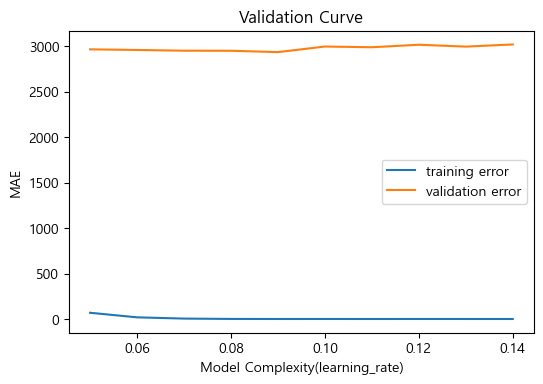

In [1031]:
XG_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", XGBRegressor(n_jobs=-1,n_estimators=170,max_depth=70))]
)
alpha = np.arange(0.05,0.15,0.01)
ts, vs = validation_curve(
    XG_pipe, X_train, y_train
    , param_name='Regression__learning_rate'
    , param_range=alpha, scoring=score
    , cv=3
    , n_jobs=-1
)
train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)
fig, ax = plt.subplots()
ax.plot(alpha, train_scores_mean, label='training error')
ax.plot(alpha, validation_scores_mean, label='validation error')
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(learning_rate)', ylabel='MAE')
ax.legend()
fig.dpi = 100

In [1062]:
XG_pipe = Pipeline(
    steps=[
    ("preprocessor", preprocessor),
    ("Regression", XGBRegressor(n_jobs=-1,n_estimators=170,max_depth=70,learning_rate =0.06))]
)
XG_pipe.fit(X_train, y_train)
XG_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoder',
                                  OrdinalEncoder(cols=['host_is_superhost',
                                                       'host_has_profile_pic',
                                                       'host_identity_verified',
                                                       'neighbourhood_cleansed',
                                                       'property_type',
                                                       'room_type',
                                                       'has_availability',
                                                       'instant_bookable',
                                                       'host_response_time',
                                                       'host_neighbourhood'],
                                                 mapping=[{'col': 'host_is_superhost',
                                                           'data_type': dtype('O'),
                                                           'mapping'...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.06,
                              max_delta_step=0, max_depth=70,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=170,
                              n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [1033]:
performance(XG_pipe)

train MAE : 22.102267245103942
val MAE : 2746.5408117495826
base model val MAE : 5657.2159429702715


2746.5408117495826

In [1034]:
# 최종 모형
# Ensemble model (Boosting)
# XGBRegressor
final_performance(XG_pipe)

test MAE : 2892.467603078931


2892.467603078931

<AxesSubplot:>

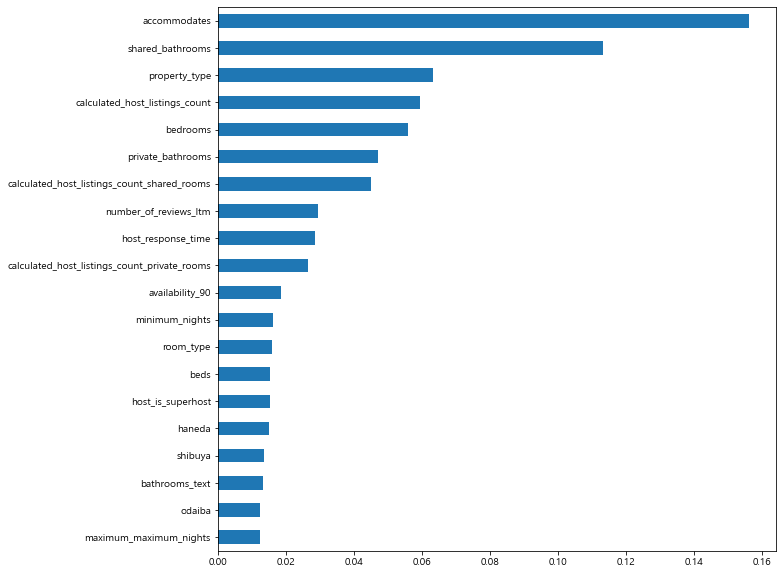

In [1035]:
plt.figure(figsize=(10,10))
pd.Series(XG_pipe["Regression"].feature_importances_, X.columns).sort_values()[-20:].plot.barh()

In [1036]:
permuter = PermutationImportance(
    XG_pipe.named_steps['Regression'], 
    scoring=score, 
    n_iter=5, 
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = XG_pipe.named_steps['preprocessor'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

<AxesSubplot:>

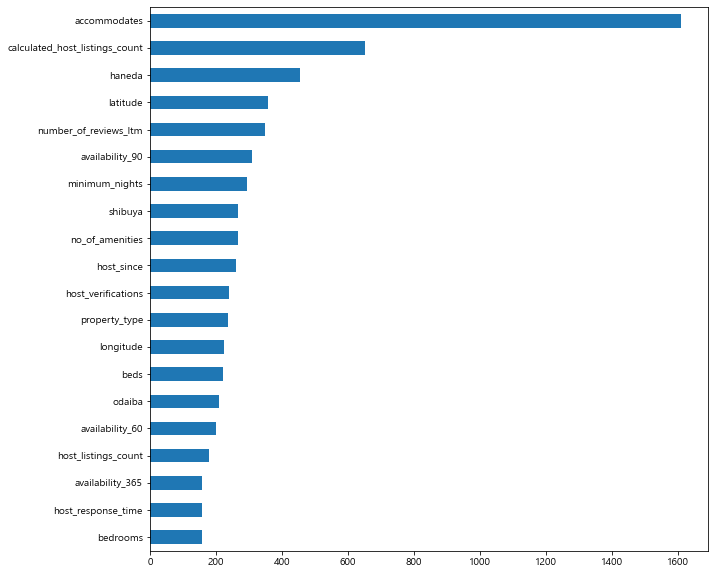

In [1037]:
plt.figure(figsize=(10,10))
pd.Series(permuter.feature_importances_, X.columns).sort_values()[-20:].plot.barh()

In [931]:
eli5.show_weights(
    permuter, 
    top=10, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=X.columns.tolist() # list 형식으로 넣어야 합니다
)

Weight,Feature
1545.0039 ± 159.4396,accommodates
634.6626 ± 69.8541,calculated_host_listings_count
535.7620 ± 39.9039,haneda
374.4904 ± 33.6670,latitude
339.3469 ± 74.2750,number_of_reviews_ltm
319.8528 ± 73.6169,minimum_nights
311.2004 ± 41.5951,no_of_amenities
294.8921 ± 42.2916,availability_90
264.4122 ± 29.8627,host_since
254.2265 ± 17.9207,shibuya


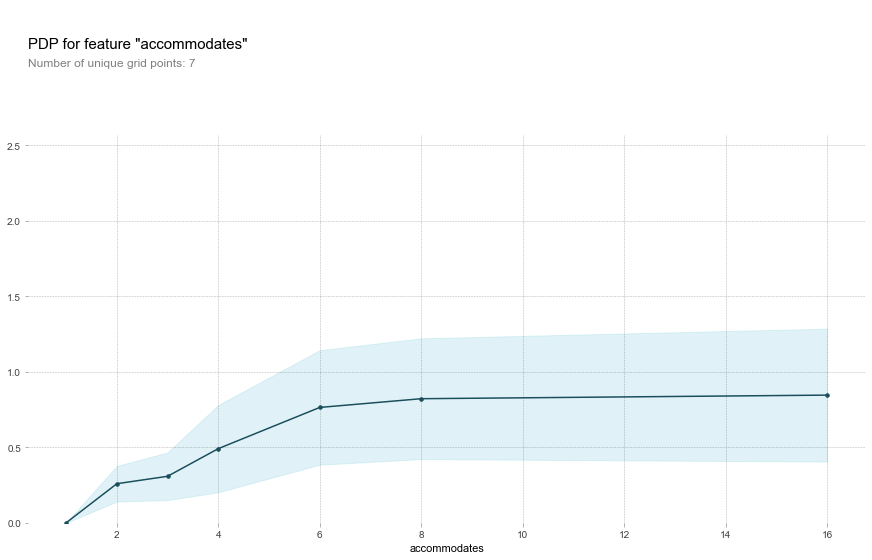

In [1038]:
# 인원수가 증가함에 따라 가격이 늘어난다
feature = 'accommodates'
isolated = pdp_isolate(
    model=XG_pipe, 
    dataset=X_val, 
    model_features=X.columns.tolist(), 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

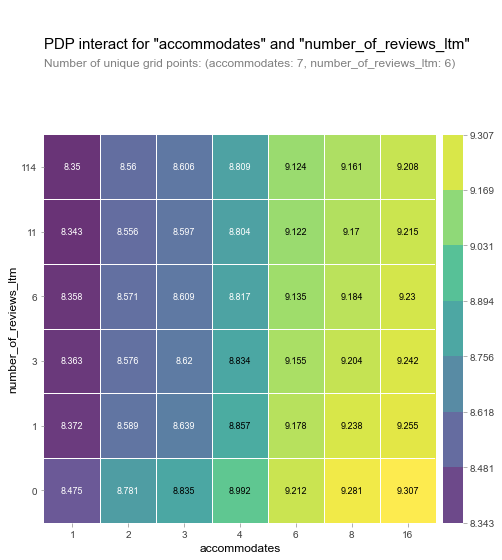

In [1040]:
features = ['accommodates', "number_of_reviews_ltm"]

interaction = pdp_interact(
    model=XG_pipe, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [1063]:
X_test_encoded = XG_pipe["preprocessor"].transform(X_test)
explainer = shap.TreeExplainer(XG_pipe["Regression"])
shap_values = explainer.shap_values(X_test_encoded.iloc[:100])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test_encoded.iloc[:100])

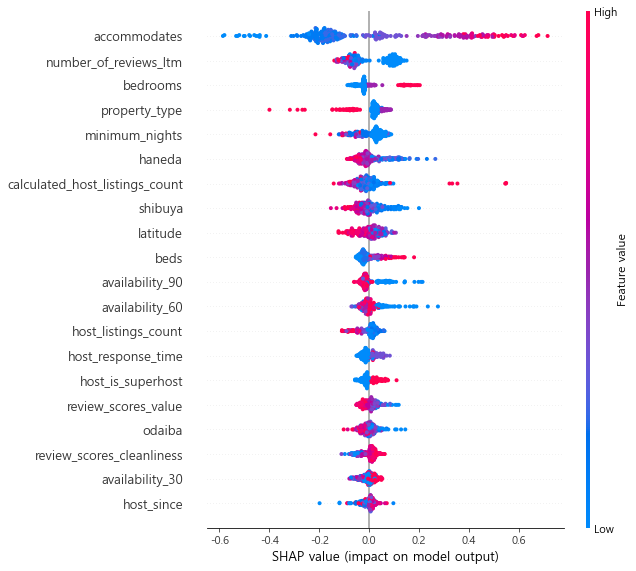

In [1064]:
shap_values = explainer.shap_values(X_test_encoded.iloc[:300])
shap.summary_plot(shap_values, X_test_encoded.iloc[:300])